## _*The Deutsch-Jozsa Algorithm*_

The [Deutsch-Jozsa algorithm](http://rspa.royalsocietypublishing.org/content/439/1907/553) is one of the earliest examples demonstrating the power of quantum computers. The algorithm deals with guessing the type of a hidden Boolean function given as an oracle. The Boolean function is promised to be either balanced, i.e., whose values are $0$ on half of its inputs, or constant, i.e., whose values are the same on all inputs.

Classically, in the best case, two queries to the oracle can determine if the hidden Boolean function is balanced; in the worst case, at least half of the inputs must be queried to determine if the hidden Boolean function is constant for all inputs. On the other hand, the Deutsch-Jozsa algorithm can determine the Boolean function with one quantum query.   

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Rudy Raymond

## Introduction <a id='introduction'></a>

The algorithm in this notebook follows that in [Cleve et al. 1997](https://arxiv.org/pdf/quant-ph/9708016.pdf). We assume that the input to the oracle $f$ is a $n$-bit string. Namely, for each $x\ in \{0,1\}^n$, the value of $f(x)$ is promised to be either constant, i.e., the same for all $x$, or balanced, i.e., exactly half of the $n$-bit string whose $f(x) = 0$.

## The Algorithm

The algorithm is quite simple as follows.
1. Prepare two quantum registers initialized to zero. The first is an $n$-qubit reqister for querying the oracle, and the second is a one-qubit register for storing the answer of the oracle
$$
|0\ldots 0\rangle |0\rangle
$$
2. Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
$$
H^{\otimes^n} |0\ldots 0\rangle |0\rangle = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle
$$
3. Flip the second register and apply the Hadamard gate. This is to store the answer of the oracle in the phase.
$$
\frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1}|i\rangle |0\rangle \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle )
$$
4. Query the oracle
$$
\frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}|i\rangle ( |0\rangle - |1\rangle ) \rightarrow \frac{1}{\sqrt{2^{n+1}}}\sum_{i=0}^{2^n-1}(-1)^{f(i)}|i\rangle ( |0\rangle - |1\rangle )
$$
5. Apply the Hadamard gate to the first register

6. Measure the first register. If it is non-zero, then conclude that the hidden Boolean function is balanced. Otherwise, conclude that it is constant.

The correctness of the conclusion of the last step can be explained as follows.

When the hidden Boolean function is constant, the quantum states before and after querying the oracle are the same. The inverse of the Hadamard gate is the Hadamard gate itself. Thus, by Step 5, we essentially reverse Step 2 to obtain the initial quantum state of all-zero at the first register.  

When the hidden Boolean function is balanced, the quantum state after querying the oracle is orthogonal to the quantum state before querying the oracle. Thus, by Step 5, when reverting the operation, we must end up with a quantum state that is orthogonal to the initial quantum state of all-zero at the first register. This means we should never obtain the all-zero state.

In [1]:
%pip install qiskit[visualization]==1.1.0
%pip install qiskit-aer==0.14.2
%pip install qiskit-algorithms==0.3.0
%pip install qiskit-ibm-runtime==0.25.0
%pip install qiskit-machine-learning==0.7.2
%pip install qiskit-nature==0.7.2
%pip install qiskit-nature-pyscf==0.4.0
%pip install qiskit-qasm3-import==0.5.0
%pip install qiskit-transpiler-service==0.4.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=9eae3e20e701e590279251207590fd596aae3725514194248392a5a231fd6d63
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## The Circuit <a id="circuit"></a>

We now implement the Deutsch-Jozsa algorithm with Qiskit by first preparing the environment.

In [2]:
# useful additional packages
import numpy as np
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

We first set the length of the $n$-bit string.

In [3]:
n = 10 # the length of the first register for querying the oracle

We then use Qiskit to program the algorithm.

In [12]:
# Choose a type of oracle at random. With probability half it is constant,
# and with the same probability it is balanced
oracleType, oracleValue = np.random.randint(2), np.random.randint(2)

if oracleType == 0:
    print("The oracle returns a constant value ", oracleValue)
else:
    print("The oracle returns a balanced function")
    a = np.random.randint(1,2**n) # this is a hidden parameter for balanced oracle.

# Creating registers
# n qubits for querying the oracle and one qubit for storing the answer
qr = QuantumRegister(n+1) #all qubits are initialized to zero
# for recording the measurement on the first register
cr = ClassicalRegister(n, name='res')

djCircuit = QuantumCircuit(qr, cr)

# Create the superposition of all input queries in the first register by applying the Hadamard gate to each qubit.
for i in range(n):
    djCircuit.h(qr[i])

# Flip the second register and apply the Hadamard gate.
djCircuit.x(qr[n])
djCircuit.h(qr[n])

# Apply barrier to mark the beginning of the oracle
djCircuit.barrier()

if oracleType == 0:#If the oracleType is "0", the oracle returns oracleValue for all input.
    if oracleValue == 1:
        #!!!PUT CODE HERE!!!
    else:
        #!!!PUT CODE HERE!!!
else: # Otherwise, it returns the inner product of the input with a (non-zero bitstring)
    for i in range(n):
        if (a & (1 << i)):
            djCircuit.cx(qr[i], qr[n])

# Apply barrier to mark the end of the oracle
djCircuit.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    djCircuit.h(qr[i])

# Measurement
djCircuit.barrier()
for i in range(n):
    djCircuit.measure(qr[i], cr[i])

The oracle returns a constant value  0


## Experiment with Simulators

We can run the above circuit on the simulator.

First, we draw the circuit.

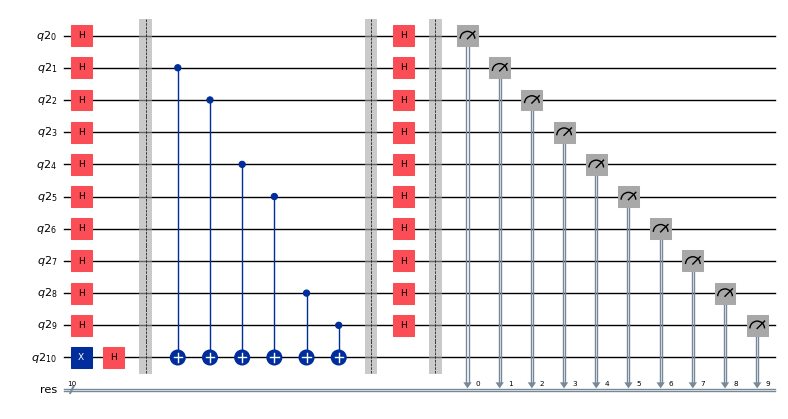

In [10]:
#draw the circuit
djCircuit.draw(output='mpl',scale=0.5)

We then run the circuit on the simulator.

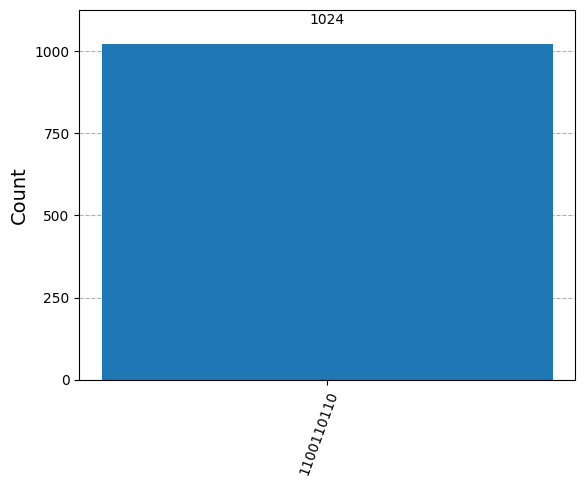

In [11]:
sampler = StatevectorSampler()
job = sampler.run([djCircuit])
results = job.result()
plot_histogram(results[0].data.res.get_counts())